# Round 1 Model
- The goal of this notebook is to focus on creating the best model to predict the first round scores of the tournament
- First, features will be engineered based on previous work in the exploratory notebook.
- Then, there will be multiple models selected to minimize Mean Squared Error

In [33]:
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

## database where clean data is stored
conn = sqlite3.connect('/Users/nickospelt/Documents/App_Projects/PGA_Score_Predictor/Data/PGA_SQL_DB/PGA.db')

# Prepare Data for Feature Importance and Model Development

In [124]:
round_one_query = """WITH 
TOURNAMENT_AVGS AS (
SELECT TOURNAMENT_NAME,
    AVG(R1_AVG_SCORE - PAR) AS R1_AVG_SCORE,
    AVG(R1_PUTTS) AS AVG_R1_PUTTS, 
    AVG(GIR_PERCENTAGE) AS AVG_GIR,
    AVG(SCRAMBLING_PERCENTAGE) AS AVG_SCRAMB,
    AVG(TOTAL_DRIVING_DISTANCE) AS AVG_DRIVE_DIST,
    AVG(FIR_PERCENTAGE) AS AVG_FIR
FROM PLAYER_TOURNAMENT_RESULTS_V2
GROUP BY 1
),
PLAYER_RATIOS AS (
SELECT PLAYER_TOURNAMENT_RESULTS_V2.TOURNAMENT_NAME, TOURNAMENT_DATE, PLAYER_NAME,
    (R1_SCORE - PAR), TOURNAMENT_AVGS.R1_AVG_SCORE, ((R1_SCORE - PAR) - TOURNAMENT_AVGS.R1_AVG_SCORE) / (TOURNAMENT_AVGS.R1_AVG_SCORE) AS R1_SCORE_RATIO,
    SCRAMBLING_PERCENTAGE, AVG_SCRAMB,(SCRAMBLING_PERCENTAGE - AVG_SCRAMB) / (AVG_SCRAMB) AS SCRAMB_RATIO,
    GIR_PERCENTAGE, AVG_GIR, (GIR_PERCENTAGE - AVG_GIR) / (AVG_GIR) AS GIR_RATIO,
    FIR_PERCENTAGE, AVG_FIR, (FIR_PERCENTAGE - AVG_FIR) / (AVG_FIR) AS FIR_RATIO,
    TOTAL_DRIVING_DISTANCE, AVG_DRIVE_DIST, (TOTAL_DRIVING_DISTANCE - AVG_DRIVE_DIST) / (AVG_DRIVE_DIST) AS DRIVE_DIST_RATIO, 
    R1_PUTTS, AVG_R1_PUTTS, (R1_PUTTS - AVG_R1_PUTTS) / (AVG_R1_PUTTS) AS R1_PUTT_RATIO
FROM PLAYER_TOURNAMENT_RESULTS_V2 LEFT JOIN TOURNAMENT_AVGS ON PLAYER_TOURNAMENT_RESULTS_V2.TOURNAMENT_NAME = TOURNAMENT_AVGS.TOURNAMENT_NAME
),
LAGGED_RATIOS AS (
SELECT TOURNAMENT_NAME, TOURNAMENT_DATE, PLAYER_NAME,
    LAG(R1_SCORE_RATIO) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P1_R1_SCORE_RATIO,
    LAG(R1_SCORE_RATIO, 2) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P2_R1_SCORE_RATIO,
    LAG(R1_SCORE_RATIO, 3) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P3_R1_SCORE_RATIO,
    LAG(SCRAMB_RATIO) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P1_SCRAMB_RATIO,
    LAG(SCRAMB_RATIO, 2) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P2_SCRAMB_RATIO,
    LAG(SCRAMB_RATIO, 3) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P3_SCRAMB_RATIO,
    LAG(DRIVE_DIST_RATIO) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P1_DRIVE_DIST_RATIO,
    LAG(DRIVE_DIST_RATIO, 2) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P2_DRIVE_DIST_RATIO,
    LAG(DRIVE_DIST_RATIO, 3) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P3_DRIVE_DIST_RATIO,
    LAG(FIR_RATIO) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P1_FIR_RATIO,
    LAG(FIR_RATIO, 2) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P2_FIR_RATIO,
    LAG(FIR_RATIO, 3) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P3_FIR_RATIO,
    LAG(GIR_RATIO) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P1_GIR_RATIO,
    LAG(GIR_RATIO, 2) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P2_GIR_RATIO,
    LAG(GIR_RATIO, 3) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P3_GIR_RATIO,
    LAG(R1_PUTT_RATIO) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P1_R1_PUTT_RATIO,
    LAG(R1_PUTT_RATIO, 2) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P2_R1_PUTT_RATIO,
    LAG(R1_PUTT_RATIO, 3) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P3_R1_PUTT_RATIO
FROM PLAYER_RATIOS
),
WEIGHTS AS (
 SELECT *,
     (CASE
         WHEN P1_GIR_RATIO IS NULL THEN NULL
         WHEN P2_GIR_RATIO IS NULL THEN 1
         WHEN P3_GIR_RATIO IS NULL THEN 0.6
         ELSE 0.5
     END) AS WEIGHT_1,
     (CASE
         WHEN P1_GIR_RATIO IS NULL THEN NULL
         WHEN P2_GIR_RATIO IS NULL THEN 0
         WHEN P3_GIR_RATIO IS NULL THEN 0.4
         ELSE 0.3
     END) AS WEIGHT_2,
     (CASE
         WHEN P1_GIR_RATIO IS NULL THEN NULL
         WHEN P2_GIR_RATIO IS NULL THEN 0
         WHEN P3_GIR_RATIO IS NULL THEN 0
         ELSE 0.2
     END) AS WEIGHT_3
 FROM LAGGED_RATIOS
)

-- This weighted average computation is where it is not clear what the best way is to handle the time series component of the player statistics
SELECT WEIGHTS.TOURNAMENT_NAME, WEIGHTS.TOURNAMENT_DATE, WEIGHTS.PLAYER_NAME, PLAYER_ID,
    (CASE 
         WHEN UPPER(WEIGHTS.TOURNAMENT_NAME) LIKE "%MASTERS%" THEN 1.0
         WHEN UPPER(WEIGHTS.TOURNAMENT_NAME) LIKE "%U.S. OPEN%" THEN 2.0
         WHEN UPPER(WEIGHTS.TOURNAMENT_NAME) LIKE "%THE OPEN%" THEN 3.0
         WHEN UPPER(WEIGHTS.TOURNAMENT_NAME) LIKE "%PGA%" THEN 4.0
         WHEN UPPER(WEIGHTS.TOURNAMENT_NAME) LIKE "%PLAYERS%" THEN 5.0
     END) AS TOURNAMENT_F,
    R1_TEMP, R1_PRECIP, R1_WIND_SPEED, R1_WIND_DIRECT,
    ELEVATION, PAR, LENGTH,
    (CASE
        WHEN WEIGHT_1 IS NULL THEN NULL
        ELSE IFNULL(P1_R1_SCORE_RATIO, 0) * WEIGHT_1 + IFNULL(P2_R1_SCORE_RATIO, 0) * WEIGHT_2 + IFNULL(P3_R1_SCORE_RATIO, 0) * WEIGHT_3
    END) AS R1_SCORE_RATIO, PLAYER_RATIOS.R1_SCORE_RATIO AS ACT_R1_SCORE_RATIO,
    (CASE
        WHEN WEIGHT_1 IS NULL THEN NULL
        ELSE IFNULL(P1_SCRAMB_RATIO, 0) * WEIGHT_1 + IFNULL(P2_SCRAMB_RATIO, 0) * WEIGHT_2 + IFNULL(P3_SCRAMB_RATIO, 0) * WEIGHT_3
    END) AS SCRAMB_RATIO, PLAYER_RATIOS.SCRAMB_RATIO AS ACT_SCRAMB_RATIO,
    (CASE
        WHEN WEIGHT_1 IS NULL THEN NULL
        ELSE IFNULL(P1_DRIVE_DIST_RATIO, 0) * WEIGHT_1 + IFNULL(P2_DRIVE_DIST_RATIO, 0) * WEIGHT_2 + IFNULL(P3_DRIVE_DIST_RATIO, 0) * WEIGHT_3
    END) AS DRIVE_DIST_RATIO, PLAYER_RATIOS.DRIVE_DIST_RATIO AS ACT_DRIVE_DIST_RATIO,
    (CASE
        WHEN WEIGHT_1 IS NULL THEN NULL
        ELSE IFNULL(P1_FIR_RATIO, 0) * WEIGHT_1 + IFNULL(P2_FIR_RATIO, 0) * WEIGHT_2 + IFNULL(P3_FIR_RATIO, 0) * WEIGHT_3
    END) AS FIR_RATIO, PLAYER_RATIOS.FIR_RATIO AS ACT_FIR_RATIO,
    (CASE
        WHEN WEIGHT_1 IS NULL THEN NULL
        ELSE IFNULL(P1_GIR_RATIO, 0) * WEIGHT_1 + IFNULL(P2_GIR_RATIO, 0) * WEIGHT_2 + IFNULL(P3_GIR_RATIO, 0) * WEIGHT_3
    END) AS GIR_RATIO, PLAYER_RATIOS.FIR_RATIO AS ACT_GIR_RATIO,
    (CASE
        WHEN WEIGHT_1 IS NULL THEN NULL
        ELSE IFNULL(P1_R1_PUTT_RATIO, 0) * WEIGHT_1 + IFNULL(P2_R1_PUTT_RATIO, 0) * WEIGHT_2 + IFNULL(P3_R1_PUTT_RATIO, 0) * WEIGHT_3
    END) AS R1_PUTT_RATIO, PLAYER_RATIOS.R1_PUTT_RATIO AS ACT_R1_PUTT_RATIO,
    R1_SCORE
FROM WEIGHTS INNER JOIN PLAYER_TOURNAMENT_RESULTS_V2 
    ON WEIGHTS.TOURNAMENT_NAME = PLAYER_TOURNAMENT_RESULTS_V2.TOURNAMENT_NAME AND WEIGHTS.PLAYER_NAME = PLAYER_TOURNAMENT_RESULTS_V2.PLAYER_NAME
    INNER JOIN PLAYER_RATIOS ON WEIGHTS.TOURNAMENT_NAME = PLAYER_RATIOS.TOURNAMENT_NAME AND WEIGHTS.PLAYER_NAME = PLAYER_RATIOS.PLAYER_NAME
ORDER BY WEIGHTS.PLAYER_NAME, WEIGHTS.TOURNAMENT_DATE"""

round_one_df = pd.read_sql_query(round_one_query, conn)
round_one_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PLAYER_ID,TOURNAMENT_F,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R1_WIND_DIRECT,ELEVATION,PAR,LENGTH,R1_SCORE_RATIO,ACT_R1_SCORE_RATIO,SCRAMB_RATIO,ACT_SCRAMB_RATIO,DRIVE_DIST_RATIO,ACT_DRIVE_DIST_RATIO,FIR_RATIO,ACT_FIR_RATIO,GIR_RATIO,ACT_GIR_RATIO,R1_PUTT_RATIO,ACT_R1_PUTT_RATIO,R1_SCORE
0,2018 U.S. Open,2018-06-14,Aaron Baddeley,22371,2.0,66.1,0.004,21.4,253,11.0,70,7440,NaN,-0.534884,NaN,-0.047069,NaN,-0.030084,NaN,-0.009579,NaN,-0.009579,NaN,-0.043000,74
1,2023 THE PLAYERS Championship,2023-03-09,Aaron Baddeley,22371,5.0,65.2,0.000,10.6,73,6.0,72,7275,-0.534884,-0.579832,-0.047069,-0.067714,-0.030084,-0.065854,-0.009579,-0.104696,0.086637,-0.104696,-0.043000,0.047183,73
2,2021 The Open Championship,2021-07-15,Aaron Rai,46414,3.0,63.8,0.000,13.8,349,100.0,70,7189,NaN,-1.000000,NaN,0.097885,NaN,-0.032888,NaN,0.246699,NaN,0.246699,NaN,-0.083296,70
3,2023 THE PLAYERS Championship,2023-03-09,Aaron Rai,46414,5.0,65.2,0.000,10.6,73,6.0,72,7275,-1.000000,-0.579832,0.097885,0.053744,-0.032888,0.003471,0.246699,0.126246,0.006647,0.126246,-0.083296,0.119403,73
4,2019 Masters Tournament,2019-04-11,Aaron Wise,49964,1.0,69.6,0.004,13.9,124,44.0,72,7475,NaN,-0.325843,NaN,-0.021406,NaN,0.025476,NaN,-0.033767,NaN,-0.033767,NaN,0.083898,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,2023 Masters Tournament,2023-04-06,Zach Johnson,24024,1.0,73.6,0.035,8.1,181,44.0,72,7545,-0.627480,-0.019608,0.032173,-0.056993,-0.036310,-0.030948,-0.010043,0.032657,-0.042323,0.032657,0.007209,0.103607,75
1725,2023 PGA Championship,2023-05-18,Zach Johnson,24024,4.0,46.8,0.000,8.0,141,155.0,70,7394,-0.315716,-0.286988,-0.001358,-0.113462,-0.034478,-0.062682,-0.011113,0.122876,0.025465,0.122876,0.048872,-0.011515,74
1726,2023 The Open,2023-07-20,Zach Johnson,24024,3.0,59.1,0.016,13.5,294,11.0,71,7383,-0.185442,-0.056604,-0.058079,0.054499,-0.046915,-0.051604,0.048520,-0.036729,-0.001673,-0.036729,0.020517,-0.115402,75
1727,2023 The Open,2023-07-20,Zack Fischer,39412,3.0,59.1,0.016,13.5,294,11.0,71,7383,NaN,-1.000000,NaN,-0.203150,NaN,0.013435,NaN,0.029671,NaN,0.029671,NaN,0.122759,71


## Feature Engineering Outside of SQL

### Weather Factor

In [3]:
def weather_weighted_average(temp, precip, wind_speed, elevation):
    weights = [0.1, 0.1, 0.3, 0.5]
    return (temp * -1 * weights[0] + elevation * weights[1] + precip * weights[2] + wind_speed * weights[3])

scaler = StandardScaler()
round_one_df[['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED', 'ELEVATION']] = scaler.fit_transform(round_one_df[['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED', 'ELEVATION']])

round_one_df['R1_WEATHER_FACTOR'] = round_one_df.apply(lambda row:
    weather_weighted_average(row['R1_TEMP'], row['R1_PRECIP'], row['R1_WIND_SPEED'], row['ELEVATION']), axis=1)
round_one_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PLAYER_ID,TOURNAMENT_F,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R1_WIND_DIRECT,ELEVATION,PAR,LENGTH,R1_SCORE_RATIO,ACT_R1_SCORE_RATIO,SCRAMB_RATIO,ACT_SCRAMB_RATIO,DRIVE_DIST_RATIO,ACT_DRIVE_DIST_RATIO,FIR_RATIO,ACT_FIR_RATIO,GIR_RATIO,ACT_GIR_RATIO,R1_PUTT_RATIO,ACT_R1_PUTT_RATIO,R1_SCORE,R1_WEATHER_FACTOR
0,2018 U.S. Open,2018-06-14,Aaron Baddeley,22371,2.0,0.104910,-0.301958,2.735493,253,-0.630375,70,7440,NaN,-0.534884,NaN,-0.047069,NaN,-0.030084,NaN,-0.009579,NaN,-0.009579,NaN,-0.043000,74,1.203631
1,2023 THE PLAYERS Championship,2023-03-09,Aaron Baddeley,22371,5.0,-0.021055,-0.330632,-0.378748,73,-0.719239,72,7275,-0.534884,-0.579832,-0.047069,-0.067714,-0.030084,-0.065854,-0.009579,-0.104696,0.086637,-0.104696,-0.043000,0.047183,73,-0.358382
2,2021 The Open Championship,2021-07-15,Aaron Rai,46414,3.0,-0.217001,-0.330632,0.543990,349,0.951406,70,7189,NaN,-1.000000,NaN,0.097885,NaN,-0.032888,NaN,0.246699,NaN,0.246699,NaN,-0.083296,70,0.289646
3,2023 THE PLAYERS Championship,2023-03-09,Aaron Rai,46414,5.0,-0.021055,-0.330632,-0.378748,73,-0.719239,72,7275,-1.000000,-0.579832,0.097885,0.053744,-0.032888,0.003471,0.246699,0.126246,0.006647,0.126246,-0.083296,0.119403,73,-0.358382
4,2019 Masters Tournament,2019-04-11,Aaron Wise,49964,1.0,0.594775,-0.301958,0.572825,124,-0.043872,72,7475,NaN,-0.325843,NaN,-0.021406,NaN,0.025476,NaN,-0.033767,NaN,-0.033767,NaN,0.083898,75,0.131961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,2023 Masters Tournament,2023-04-06,Zach Johnson,24024,1.0,1.154621,-0.079730,-1.099637,181,-0.043872,72,7545,-0.627480,-0.019608,0.032173,-0.056993,-0.036310,-0.030948,-0.010043,0.032657,-0.042323,0.032657,0.007209,0.103607,75,-0.693587
1725,2023 PGA Championship,2023-05-18,Zach Johnson,24024,4.0,-2.596345,-0.330632,-1.128473,141,1.928912,70,7394,-0.315716,-0.286988,-0.001358,-0.113462,-0.034478,-0.062682,-0.011113,0.122876,0.025465,0.122876,0.048872,-0.011515,74,-0.210901
1726,2023 The Open,2023-07-20,Zach Johnson,24024,3.0,-0.874819,-0.215934,0.457483,294,-0.630375,71,7383,-0.185442,-0.056604,-0.058079,0.054499,-0.046915,-0.051604,0.048520,-0.036729,-0.001673,-0.036729,0.020517,-0.115402,75,0.188406
1727,2023 The Open,2023-07-20,Zack Fischer,39412,3.0,-0.874819,-0.215934,0.457483,294,-0.630375,71,7383,NaN,-1.000000,NaN,-0.203150,NaN,0.013435,NaN,0.029671,NaN,0.029671,NaN,0.122759,71,0.188406


### Weighting Golf Stat Features based on half life

In [4]:
def convert_string_to_date(date_string):
    return datetime.strptime(date_string, "%Y-%m-%d")

def compute_days_between(date_one, date_two):
    duration = date_two - date_one
    return duration.days

def compute_half_life_weight(half_life, days):
    return np.exp(-1 * np.log(2) / half_life * days)

# for each row, need to look at all previous tournaments for that player. and calculate weights based on the different between that rows tournament date and the other rows tournament weight.
def calc_weighted_avgs(df, player_name, tournament_date, half_life, feature):
    prev_rounds_df = df.copy()
    tournament_date = convert_string_to_date(tournament_date)
    prev_rounds_df.loc[:, 'TOURNAMENT_DATE'] = prev_rounds_df.apply(lambda row: convert_string_to_date(row['TOURNAMENT_DATE']), axis=1)
    prev_rounds_df = prev_rounds_df.loc[(prev_rounds_df['PLAYER_NAME'] == player_name) & (prev_rounds_df['TOURNAMENT_DATE'] < tournament_date)]

    if prev_rounds_df.shape[0] == 0:
        return None

    prev_rounds_df['DAYS_SINCE'] = prev_rounds_df.apply(lambda row: compute_days_between(row['TOURNAMENT_DATE'], tournament_date), axis=1)
    prev_rounds_df['WEIGHT'] = prev_rounds_df.apply(lambda row: compute_half_life_weight(half_life, row['DAYS_SINCE']), axis=1)

    weight_sum = prev_rounds_df['WEIGHT'].sum()
    prev_rounds_df['WEIGHTED_FEATURE'] = prev_rounds_df['WEIGHT'] * prev_rounds_df[feature]
    weighted_feature_sum = prev_rounds_df['WEIGHTED_FEATURE'].sum()

    return weighted_feature_sum / weight_sum

# Apply the relevant half life values for each of the factors based on the half-life values from the research paper
round_one_df['HL_R1_SCORE_RATIO'] = round_one_df.apply(lambda row: calc_weighted_avgs(round_one_df, row['PLAYER_NAME'], row['TOURNAMENT_DATE'], 150, "ACT_R1_SCORE_RATIO"), axis=1)
round_one_df['HL_SCRAMB_RATIO'] = round_one_df.apply(lambda row: calc_weighted_avgs(round_one_df, row['PLAYER_NAME'], row['TOURNAMENT_DATE'], 150, "ACT_SCRAMB_RATIO"), axis=1)
round_one_df['HL_DRIVE_DIST_RATIO'] = round_one_df.apply(lambda row: calc_weighted_avgs(round_one_df, row['PLAYER_NAME'], row['TOURNAMENT_DATE'], 50, "ACT_DRIVE_DIST_RATIO"), axis=1)
round_one_df['HL_FIR_RATIO'] = round_one_df.apply(lambda row: calc_weighted_avgs(round_one_df, row['PLAYER_NAME'], row['TOURNAMENT_DATE'], 50, "ACT_FIR_RATIO"), axis=1)
round_one_df['HL_GIR_RATIO'] = round_one_df.apply(lambda row: calc_weighted_avgs(round_one_df, row['PLAYER_NAME'], row['TOURNAMENT_DATE'], 150, "ACT_GIR_RATIO"), axis=1)
round_one_df['HL_R1_PUTT_RATIO'] = round_one_df.apply(lambda row: calc_weighted_avgs(round_one_df, row['PLAYER_NAME'], row['TOURNAMENT_DATE'], 150, "ACT_R1_PUTT_RATIO"), axis=1)


#### Example of how the Half-Life captures a players past performance

In [5]:
round_one_df[['TOURNAMENT_DATE', 'TOURNAMENT_NAME', 'ACT_R1_PUTT_RATIO', 'R1_PUTT_RATIO', 'HL_R1_PUTT_RATIO']].loc[round_one_df['PLAYER_NAME'] == "Aaron Wise"]

,TOURNAMENT_DATE,TOURNAMENT_NAME,ACT_R1_PUTT_RATIO,R1_PUTT_RATIO,HL_R1_PUTT_RATIO
4,2019-04-11,2019 Masters Tournament,0.083898,NaN,NaN
5,2019-05-16,2019 PGA Championship,-0.102217,0.083898,0.083898
6,2019-06-13,2019 U.S. Open,-0.119483,-0.027771,-0.016668
7,2019-07-18,2019 The Open Championship,0.016949,-0.073627,-0.055820
8,2021-03-11,2021 THE PLAYERS Championship,-0.091346,-0.047814,-0.033318
9,2021-05-20,2021 PGA Championship,-0.123391,-0.064485,-0.081664
10,2022-03-10,2022 THE PLAYERS Championship,0.106816,-0.085710,-0.103995
11,2022-05-19,2022 PGA Championship,0.038724,-0.001879,0.038419
12,2022-06-16,2022 U.S. Open,-0.128606,0.026729,0.038566
13,2022-07-14,2022 The Open,0.125445,-0.031322,-0.020719


# Develop Model based on Previous 3 Rounds

## Identify Feature and Target to be used in Train/Test for Feature Importance

In [6]:
round_one_features = ['TOURNAMENT_F', 'R1_WEATHER_FACTOR', 'PAR', 'LENGTH', 'R1_SCORE_RATIO', 'SCRAMB_RATIO', 'DRIVE_DIST_RATIO', 'FIR_RATIO', 'GIR_RATIO', 'R1_PUTT_RATIO']
round_one_target = 'R1_SCORE'
round_one_feaures_and_target = ['TOURNAMENT_F', 'R1_WEATHER_FACTOR', 'PAR', 'LENGTH', 'R1_SCORE_RATIO', 'SCRAMB_RATIO', 'DRIVE_DIST_RATIO', 'FIR_RATIO', 'GIR_RATIO', 'R1_PUTT_RATIO', 'R1_SCORE']

In [119]:
round_one_df = round_one_df.dropna()
X = round_one_df[round_one_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = round_one_df[round_one_target]

X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_scaled, columns=round_one_features), y, test_size=0.2)

## Feature Importance and Selection

### Create a Correlation Map To Determine Which Factors Are Correlated to Each Other

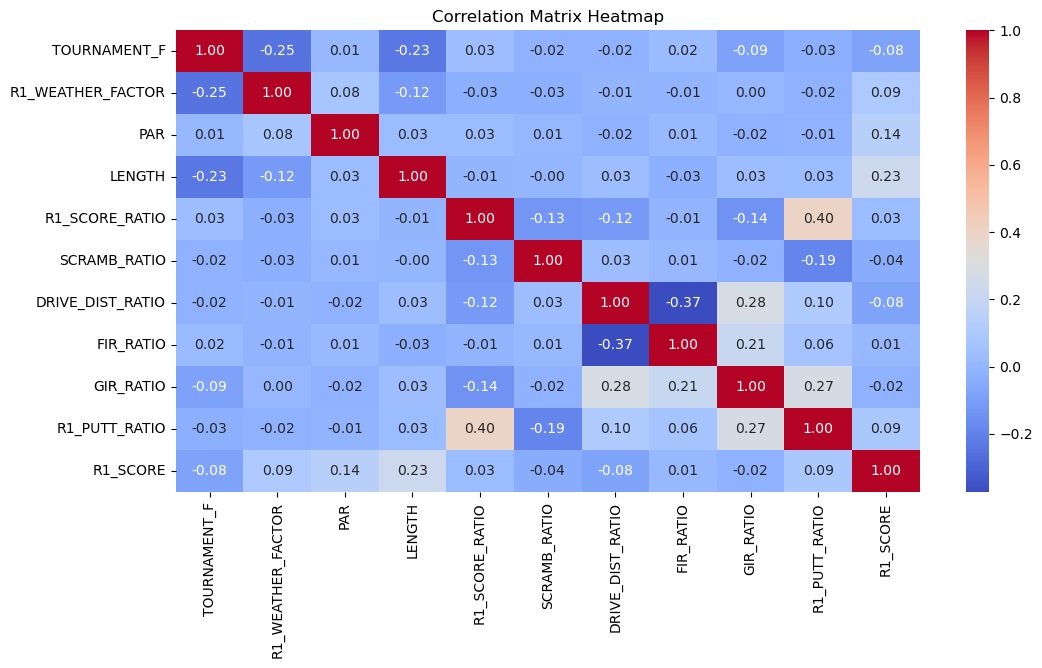

In [26]:
# Compute correlation matrix
correlation_matrix = round_one_df[round_one_feaures_and_target].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

#### Takeaways
- Elevation is highly correlated with the weather. Is there a way to combine this into the weather factor?
- The player statistic ratios are correlated with each other. This proves the basis on which strokes gained was created. May need to transition to those statistics opposed to straight percentages.
- Also, the ratios are not highly correlated to the round score. Is this due to the way in which ratios are derived based on historical data? (weighted average of previous scores (max of previous 3))


### Linear Regression for Feature Importance

In [27]:
linear_regression_model = LinearRegression()

# Train the model
linear_regression_model.fit(X_train, y_train)

# Training Stats
y_train_predict = linear_regression_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
r2_train = r2_score(y_train, y_train_predict)

# Testing Stats
y_test_predict = linear_regression_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_predict)
mae_test = mean_absolute_error(y_test, y_test_predict)
r2_test = r2_score(y_test, y_test_predict)

# Training and Test Performance
print(f"Training: MSE: {mse_train}, MAE: {mae_train}, R^2: {r2_train}")
print(f"Testing: MSE: {mse_test}, MAE: {mae_test}, R^2: {r2_test}")

# Feature Importance
coefficients = linear_regression_model.coef_
round_1 = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficients': coefficients,
}).sort_values(by=['Coefficients'], ascending=False)
print("FEATURES:")
print(round_1)

Training: MSE: 5.915268728306056, MAE: 1.9418019780868863, R^2: 0.09376149254042554
Testing: MSE: 5.805517874072752, MAE: 1.937127442054126, R^2: 0.1275352818367198
FEATURES:
             Feature  Coefficients
3             LENGTH      0.601962
2                PAR      0.310621
9      R1_PUTT_RATIO      0.253891
1  R1_WEATHER_FACTOR      0.249513
0       TOURNAMENT_F     -0.027800
8          GIR_RATIO     -0.066005
7          FIR_RATIO     -0.074961
5       SCRAMB_RATIO     -0.086369
4     R1_SCORE_RATIO     -0.107553
6   DRIVE_DIST_RATIO     -0.256557


- This echos what was seen in the correlation map. Length with the largest correlation and by far the largest coefficent.
- For these results to improve need to decrease the correlation between features and revisit how the ratios are calculated historically
- when combined elevation into the weather factor feature and removed the player id field model performance increased. This shows removing features that have unexpected correlations between each other can improve model performance.

### Lasso Regression for Feature Selection

In [28]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

lasso_cv = GridSearchCV(Lasso(), {'alpha': alphas}, cv=5)
lasso_cv.fit(X_train, y_train)

print("Best alpha for Lasso:", lasso_cv.best_params_['alpha'])

# Display feature importance
lasso_importance = np.abs(lasso_cv.best_estimator_.coef_)
lasso_features = pd.DataFrame({'Feature': X_train.columns, 'Importance': lasso_importance})
lasso_features = lasso_features.sort_values(by='Importance', ascending=False)
print()
print("Lasso Feature Importance:")
print(lasso_features)

Best alpha for Lasso: 0.001

Lasso Feature Importance:
             Feature  Importance
3             LENGTH    0.601092
2                PAR    0.309548
6   DRIVE_DIST_RATIO    0.254893
9      R1_PUTT_RATIO    0.251467
1  R1_WEATHER_FACTOR    0.248669
4     R1_SCORE_RATIO    0.105081
5       SCRAMB_RATIO    0.085460
7          FIR_RATIO    0.073594
8          GIR_RATIO    0.064695
0       TOURNAMENT_F    0.027174


### Random Forrest for Feature Importance

In [29]:
param_grid = {
    'n_estimators': [40, 50, 60],
    'max_depth': [3, 5, 7],
    'min_samples_split': [5, 10, 12],
    'min_samples_leaf': [5, 7, 9],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False]
}

random_forrest_model = RandomForestClassifier()

grid_search = GridSearchCV(
    estimator=random_forrest_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error'
)
grid_search.fit(X_train, y_train)

# Training Results
optimal_random_forrest = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_estimator_}")
print(f"Training neg. MSE: {grid_search.best_score_}")

feature_importances = pd.DataFrame({
    "Feature": round_one_features,
    "Importance": optimal_random_forrest.feature_importances_
}).sort_values(by="Importance", ascending=False)
print(feature_importances)

# Testing Stats
y_test_predict = optimal_random_forrest.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_predict)
mae_test = mean_absolute_error(y_test, y_test_predict)
r2_test = r2_score(y_test, y_test_predict)

print(f"Testing: MSE: {mse_test}, MAE: {mae_test}")

/Users/nickospelt/anaconda3/envs/pga_model/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: RandomForestClassifier(max_depth=3, min_samples_leaf=9, min_samples_split=5,
                       n_estimators=60)
Training neg. MSE: -6.4866402116402115
             Feature  Importance
3             LENGTH    0.144070
7          FIR_RATIO    0.123350
9      R1_PUTT_RATIO    0.123282
4     R1_SCORE_RATIO    0.116577
6   DRIVE_DIST_RATIO    0.112596
5       SCRAMB_RATIO    0.107762
1  R1_WEATHER_FACTOR    0.094234
8          GIR_RATIO    0.079750
2                PAR    0.052700
0       TOURNAMENT_F    0.045679
Testing: MSE: 6.634686346863469, MAE: 2.007380073800738


/Users/nickospelt/anaconda3/envs/pga_model/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


- Dropped a whole mse from initial stat_to_score_model
- The focus was on removing correlation between parameters and improving the feature ratios used on past performance
- In next iteration, trying to do a better job of utilizing historical data and utilizing statistics such as strokes gained to minimize correlation between features.


## XGBoost to Get Benchmark on Performance

In [122]:
kf = KFold(n_splits=5, shuffle=True)
xgb_model = XGBRegressor(objective='reg:squarederror')

param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [30, 40, 50, 60],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

xgb_cv = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
    scoring='neg_mean_squared_error', cv=kf, n_jobs=-1, return_train_score=True)
xgb_cv.fit(X_scaled, y)

# Convert results into a DataFrame
cv_results = pd.DataFrame(xgb_cv.cv_results_)

# Get best model index
best_xgb_index = xgb_cv.best_index_
best_xgb_model = xgb_cv.best_estimator_

# Retrieve Training and Testing MSE
train_mse = -cv_results.loc[best_xgb_index, 'mean_train_score']
test_mse = -cv_results.loc[best_xgb_index, 'mean_test_score']
params = cv_results.loc[best_xgb_index, 'params']

# Retrieve Feature Importance
feature_importance = best_xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': round_one_features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Best Hyperparameters:", params)
print("Feature Importance", importance_df)
print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)

Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 30, 'subsample': 0.9}
Feature Importance              Feature  Importance
3             LENGTH    0.202778
1  R1_WEATHER_FACTOR    0.130134
2                PAR    0.119251
9      R1_PUTT_RATIO    0.100856
0       TOURNAMENT_F    0.098337
6   DRIVE_DIST_RATIO    0.074392
7          FIR_RATIO    0.070804
4     R1_SCORE_RATIO    0.069705
5       SCRAMB_RATIO    0.068065
8          GIR_RATIO    0.065679
Training MSE: 4.830661500571
Testing MSE: 5.655937059710529


/Users/nickospelt/anaconda3/envs/pga_model/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


- This is the best performance out of the three models tried. Although, linear regression was there to test feature importance.
- All three models are indicating that the tournament_f feature is not important. This feature can be removed.
- This model also improved on the previous xgb model by about 1 MSE.

# Develop Model based on HL of all previous models

## Identify Feature and Target to be used in Train/Test for Feature Importance

In [31]:
round_one_HL_features = ['TOURNAMENT_F', 'R1_WEATHER_FACTOR', 'PAR', 'LENGTH', 'HL_R1_SCORE_RATIO', 'HL_SCRAMB_RATIO', 'HL_DRIVE_DIST_RATIO', 'HL_FIR_RATIO', 'HL_GIR_RATIO', 'HL_R1_PUTT_RATIO']
round_one_target = 'R1_SCORE'
round_one_HL_feaures_and_target = ['TOURNAMENT_F', 'R1_WEATHER_FACTOR', 'PAR', 'LENGTH', 'HL_R1_SCORE_RATIO', 'HL_SCRAMB_RATIO', 'HL_DRIVE_DIST_RATIO', 'HL_FIR_RATIO', 'HL_GIR_RATIO', 'HL_R1_PUTT_RATIO', 'R1_SCORE']

X_HL = round_one_df[round_one_HL_features]
scaler = StandardScaler()
X_HL_scaled = scaler.fit_transform(X_HL)
y = round_one_df[round_one_target]

X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_HL_scaled, columns=round_one_HL_features), y, test_size=0.2)

## Lasso Regression for Feature Selection

In [118]:
kf = KFold(n_splits=5, shuffle=True)

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

lasso = Lasso()
lasso_cv = GridSearchCV(lasso, param_grid, cv=kf, scoring='neg_mean_squared_error', return_train_score=True)
lasso_cv.fit(X_HL_scaled, y)

# Get best model index
best_index = lasso_cv.best_index_
best_model = lasso_cv.best_estimator_

# Convert results into a DataFrame
cv_results = pd.DataFrame(lasso_cv.cv_results_)

# Retrieve Training and Testing MSE
train_mse = -cv_results.loc[best_index, 'mean_train_score']
test_mse = -cv_results.loc[best_index, 'mean_test_score']
params = cv_results.loc[best_index, 'params']

# Retrieve Training and Testing MSE
train_mse = -cv_results.loc[best_index, 'mean_train_score']
test_mse = -cv_results.loc[best_index, 'mean_test_score']
params = cv_results.loc[best_index, 'params']

# Retrieve Feature Importance
feature_importance = np.abs(best_model.coef_)
importance_df = pd.DataFrame({'Feature': round_one_HL_features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Best Hyperparameters:", params)
print("Feature Importance", importance_df)
print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)

Best Hyperparameters: {'alpha': 0.01}
Feature Importance                Feature  Importance
3               LENGTH    0.589541
2                  PAR    0.316941
6  HL_DRIVE_DIST_RATIO    0.294635
1    R1_WEATHER_FACTOR    0.271862
8         HL_GIR_RATIO    0.213777
9     HL_R1_PUTT_RATIO    0.203158
7         HL_FIR_RATIO    0.152076
5      HL_SCRAMB_RATIO    0.039738
4    HL_R1_SCORE_RATIO    0.038501
0         TOURNAMENT_F    0.004753
Training MSE: 5.881665867727536
Testing MSE: 6.015103463062024


## XGBoost to Get Benchmark on Performance

In [94]:
kf = KFold(n_splits=5, shuffle=True)
xgb_model = XGBRegressor(objective='reg:squarederror')

param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [30, 40, 50, 60],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

xgb_cv = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
    scoring='neg_mean_squared_error', cv=kf, n_jobs=-1, return_train_score=True)
xgb_cv.fit(X_HL_scaled, y)

# Convert results into a DataFrame
cv_results = pd.DataFrame(xgb_cv.cv_results_)

# Get best model index
best_xgb_index = xgb_cv.best_index_
best_xgb_model = xgb_cv.best_estimator_

# Retrieve Training and Testing MSE
train_mse = -cv_results.loc[best_xgb_index, 'mean_train_score']
test_mse = -cv_results.loc[best_xgb_index, 'mean_test_score']
params = cv_results.loc[best_xgb_index, 'params']

# Retrieve Feature Importance
feature_importance = best_xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': round_one_HL_features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Best Hyperparameters:", params)
print("Feature Importance", importance_df)
print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)

Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 60, 'subsample': 0.8}
Feature Importance                Feature  Importance
3               LENGTH    0.215511
2                  PAR    0.130250
1    R1_WEATHER_FACTOR    0.128077
0         TOURNAMENT_F    0.090215
9     HL_R1_PUTT_RATIO    0.087296
6  HL_DRIVE_DIST_RATIO    0.075532
8         HL_GIR_RATIO    0.071867
4    HL_R1_SCORE_RATIO    0.070663
5      HL_SCRAMB_RATIO    0.067101
7         HL_FIR_RATIO    0.063488
Training MSE: 4.188255398173768
Testing MSE: 5.659028999418994


- No apparent gain in performance from the simple lagged features.